In [1]:
import tensorflow as tf
import keras as ker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling

### Variables

In [2]:
# No tocar
num_clases = 26
# La foto es 128x96
xpixel = 224
ypixel = 224
# Tocar
n_neuronas_conv1 = 64
n_neuronas_conv2 = 128
n_neuronas_conv3 = 256
l_rate = 0.00001  # empezar en 0.001 e ir bajando para el estudio
epoch = 15
batch = 16  # Realmente en 1 esta bien esto es mas para tiempos de ejecucion con grandes cantidades de datos

### Meter Datos

In [3]:
def meterdatos():
    directorio = r'../Dataset/'
    df = pd.read_csv(directorio + 'driver_imgs_list.csv')

    fotos = df['img'].values
    conductores = df['subject'].values
    clases = df['classname'].values
    # lo de rutas es magico la vd jejejejej
    rutas = clases + '/' + fotos
    dataset = pd.DataFrame([rutas , conductores])
    imagenes = ImageDataGenerator(validation_split=0.2) #Aqui podemos hacer augmentation

    directorio2 = r'../Dataset/imgs/train/'
    datasetEntero = dataset.T
    datasetEntero.columns = ['fotos','conductores'] #que sino no  sabe que cojer xcol e ycol


    entrenamiento = imagenes.flow_from_dataframe(
        dataframe=datasetEntero,
        directory=directorio2,
        x_col="fotos",
        y_col="conductores",
        subset="training",
        batch_size=batch,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(xpixel,ypixel)
    )
    validacion = imagenes.flow_from_dataframe(
        dataframe=datasetEntero,
        directory=directorio2,
        x_col="fotos",
        y_col="conductores",
        subset="validation",
        batch_size=batch,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(xpixel,ypixel)
    )
    return entrenamiento , validacion


### Modelar Red

In [4]:
def Modelar_red_trampas(x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(x, y, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))  # drop 50% of neurons
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

### Entrenar

In [5]:
def Entrenar(m, e, v, epo, b):
    # Para parar segun el criterio de la pr
    elcallback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.2,
        patience=2,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=False,
    )
    
    history = m.fit(
        e,
        validation_data=v,
        epochs=epo,
        batch_size=b,
        verbose=1,  # Esto te imprime un progress bar con informacion
        shuffle=True,
        callbacks=elcallback
    )
    return history

### Evaluacion

In [6]:
def Evaluar(m, e_test):
    return m.evaluate(e_test,verbose=1)

### Funciones Esteticas

In [7]:
# Pintamos nuestro modelo

def pintarmodelo(modelo):
    tf.keras.utils.plot_model(
        modelo,
        to_file='model.png',
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96,
        layer_range=None,
        show_layer_activations=False
    )

# Pintamos imagenes
def mostrarimagenes(imagenes, batch):
    img, labels = next(imagenes)
    for i in range(batch):
        plt.imshow(img[i, :, :, :])
        plt.title(labels[i])
        plt.show()


### Guardar y cargar el modelo neuronal deseado

In [8]:
def cargarmodelo():
    model = ker.models.load_model('path/to/location')  # Carga modelos
    return model
    
def guardarmodelo():
    model.save('ModeloGuardado')  # guarda el modelo en la ruta que desees

### Preparación para entrenar

In [9]:
train, validation = meterdatos()
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red_trampas(xpixel, ypixel, l_rate)

Found 17940 validated image filenames belonging to 26 classes.
Found 4484 validated image filenames belonging to 26 classes.


### Ejecución

Epoch 1/15
1122/1122 [==============================] - 91s 79ms/step - loss: 0.9123 - accuracy: 0.7628 - val_loss: 12.6290 - val_accuracy: 0.0239
Epoch 2/15
1122/1122 [==============================] - 89s 80ms/step - loss: 0.0259 - accuracy: 0.9952 - val_loss: 14.4025 - val_accuracy: 0.0239
Epoch 3/15
1122/1122 [==============================] - 89s 80ms/step - loss: 0.0107 - accuracy: 0.9977 - val_loss: 14.7109 - val_accuracy: 0.0239


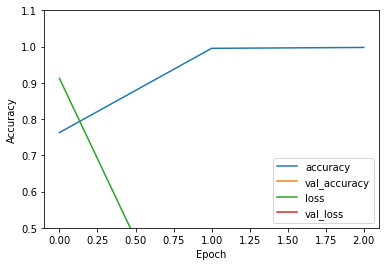

In [10]:
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

### Evaluación

In [11]:
train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

281/281 [==============================] - 17s 59ms/step - loss: 14.7109 - accuracy: 0.0239
